## Interpretation

The goal of after model training in 04_model_training.ipynb is to understand how each model makes predictions on new data. Permutation feature importance and SHAP are useful in making the results interpretable, explaining how each feature affects the models' predictions.

Permutation feature importance is a global model-agnostic post-hoc method, measuring the increase in the prediction error of the model after permuting the values of a feature. A larger increase in prediction error indicates higher feature importance. However, feature importance does not inform how the feature influences the prediction as it is measured by prediction error. Feauture importance is just an internal ranking of features.

SHapley Additive exPlanations (SHAP) is a local model-agnostic post-hoc method, explaining the prediction of a model by computing the contribution of each feature to the prediction. Unlike permutation feature importance, the SHAP summary plot combines feature importance with feature effects. The summary plot orders the features by importance in the y-axis, and shows how that feature increases or decreases the prediction relative to the base value, given a high or low feature value.

Reference : https://christophm.github.io/interpretable-ml-book/overview.html

In [10]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import joblib
import pickle
import tensorflow as tf

In [11]:
# Read the data and re-introduce the train-test split
df = pd.read_csv("../data/processed/nhanes_data_processed_label_encoded.csv")

with open("../data/results/split_data.pkl", "rb") as f:
    split_data = pickle.load(f)

with open("../data/results/metadata.pkl", "rb") as f:
    metadata = pickle.load(f)
feature_names = metadata["feature_names"]

RANDOM_STATE = 42
X_train = split_data["X_train"]
X_train_scaled = split_data["X_train_scaled"]
y_train = split_data["y_train"]
X_test = split_data["X_test"]
X_test_scaled = split_data["X_test_scaled"]
y_test = split_data["y_test"]

In [12]:
# Load models
dt_model = joblib.load('../models/decision_tree_model.pkl')
rf_model = joblib.load('../models/random_forest_model.pkl')
xgb_model = joblib.load('../models/xgboost_model.pkl')
adb_model = joblib.load('../models/adaboost_model.pkl')
lgr_model = joblib.load('../models/logistic_regression_model.pkl')
knn_model = joblib.load('../models/k-nearest_neighbors_model.pkl')
svc_model = joblib.load('../models/support_vector_machine_model.pkl')
nn_model = tf.keras.models.load_model("../models/neural_network_model.keras", compile=True)

models = {
    "Decision Tree": dt_model,
    "Random Forest": rf_model,
    "XGBoost": xgb_model,
    "AdaBoost": adb_model,
    "Logistic Regression": lgr_model,
    "K-Nearest Neighbors": knn_model,
    "Support Vector Machine": svc_model,
    "Neural Network": nn_model
}

In [13]:
# # Extract scaler from pipeline models
# lgr_scaler = lgr_model.named_steps["standardscaler"]
# X_train_scaled = lgr_scaler.transform(X_train)
# X_test_scaled = lgr_scaler.transform(X_test)

## Permutation Feature Importance

Reference : https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html#sklearn.inspection.permutation_importance

In [15]:
from sklearn.inspection import permutation_importance

In [16]:
# Create a wrapper class for the neural network model to use with sklearn
from sklearn.base import BaseEstimator

class NeuralNetworkWrapper(BaseEstimator):
    def __init__(self, model, scaler=None):
        self.model = model
        self.scaler = scaler
        
    def fit(self, X, y):
        return self
    
    def predict(self, X):
        """Return class predictions"""
        if self.scaler is not None:
            X_scaled = self.scaler.transform(X)
        else:
            X_scaled = X
            
        logits = self.model.predict(X_scaled, verbose=0)
        return np.argmax(logits, axis=1)
    
    def predict_proba(self, X):
        """Return class probabilities"""
        if self.scaler is not None:
            X_scaled = self.scaler.transform(X)
        else:
            X_scaled = X
            
        logits = self.model.predict(X_scaled, verbose=0)
        exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))
        return exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

In [17]:
# Calculate permutation importance for each model
perm_importance_results = {}

for model_name, model in models.items():
    if model_name != "Neural Network":
        perm_result = permutation_importance(model, X_test, y_test,
                                            scoring="f1_macro",
                                            n_repeats=10,
                                            n_jobs=-1,
                                            random_state=RANDOM_STATE
                                            )
    else:
        nn_wrapper = NeuralNetworkWrapper(nn_model)
        perm_result = permutation_importance(nn_wrapper, X_test_scaled, y_test,
                                            scoring="f1_macro",
                                            n_repeats=10,
                                            n_jobs=-1,
                                            random_state=RANDOM_STATE
                                            )
    perm_importance_results[model_name] = pd.DataFrame({"feature" : feature_names,
                                                            "importance_mean": perm_result.importances_mean,
                                                            "importance_std": perm_result.importances_std,                       
                                }).sort_values("importance_mean", ascending=False)

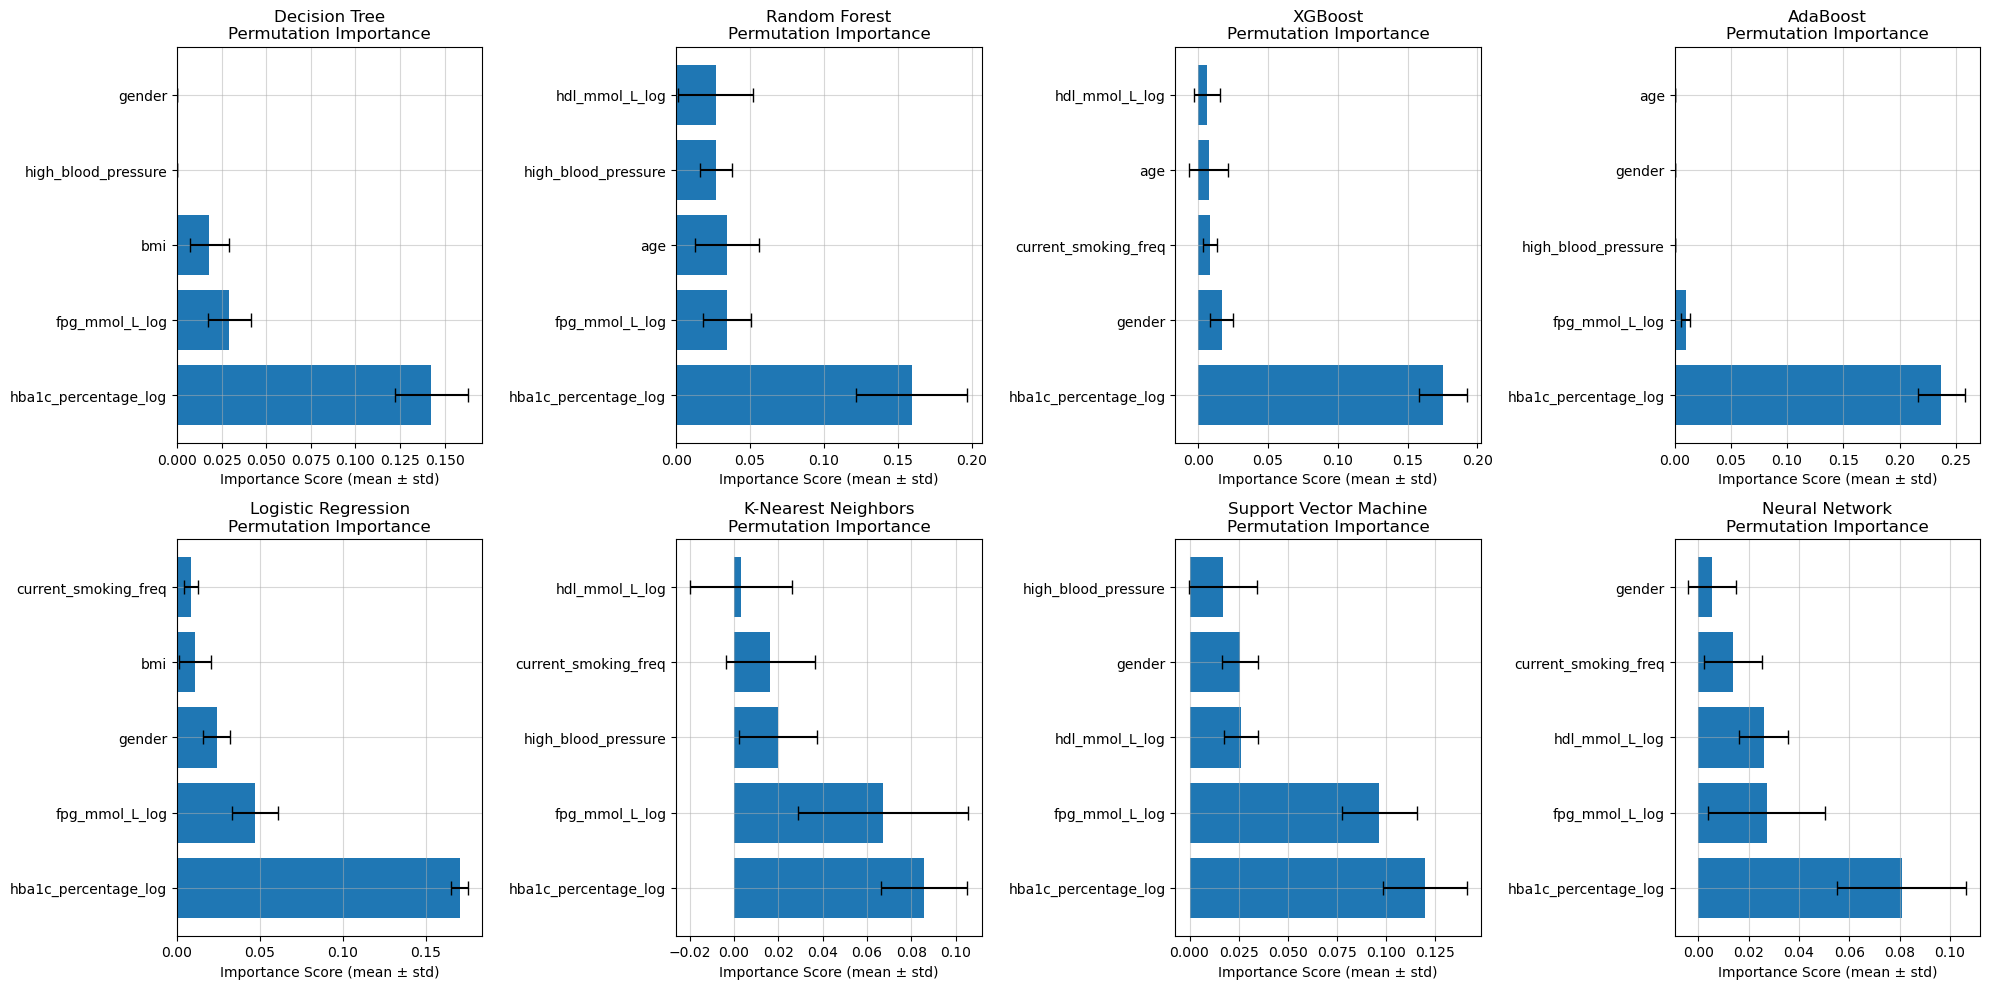

In [18]:
# Create visualisation of permutation importance for each model
fig, axes = plt.subplots(2, 4, figsize=(20,10))
axes = axes.ravel()

for idx, (model_name, importance_df) in enumerate(perm_importance_results.items()):
    ax = axes[idx]
    
    # Display the top 5 features only
    top_features = importance_df.head(5)
    
    ax.barh(range(len(top_features)), top_features["importance_mean"], xerr=top_features["importance_std"], capsize=5)
    ax.set_yticks(range(len(top_features)))
    ax.set_yticklabels(top_features["feature"])
    ax.set_xlabel("Importance Score (mean ± std)")
    ax.set_title(f"{model_name}\nPermutation Importance")
    ax.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()

In [19]:
# Create comparison table
importance_comparison = pd.DataFrame()

for model_name, importance_df in perm_importance_results.items():
    importance_comparison[model_name] = importance_df.set_index("feature")["importance_mean"]

importance_comparison["Average"] = importance_comparison.mean(axis=1)
importance_comparison = importance_comparison.sort_values("Average", ascending=False)

print("Feature importance comparison across models:")
print(importance_comparison.round(4))

Feature importance comparison across models:
                      Decision Tree  Random Forest  XGBoost  AdaBoost  \
feature                                                                 
hba1c_percentage_log         0.1426         0.1593   0.1752    0.2373   
fpg_mmol_L_log               0.0293         0.0346   0.0034    0.0098   
hdl_mmol_L_log               0.0000         0.0267   0.0065    0.0000   
gender                       0.0000         0.0195   0.0167    0.0000   
current_smoking_freq         0.0000         0.0123   0.0087    0.0000   
high_blood_pressure          0.0000         0.0270  -0.0012    0.0000   
bmi                          0.0182         0.0233   0.0031   -0.0017   
age                         -0.0310         0.0345   0.0074    0.0000   

                      Logistic Regression  K-Nearest Neighbors  \
feature                                                          
hba1c_percentage_log               0.1704               0.0857   
fpg_mmol_L_log            

## SHAP (SHapeley Additive exPlanations)

Reference : https://shap.readthedocs.io/en/latest/api.html#explanation

In [20]:
import shap

In [21]:
# For Tree-based models (AdaBoost is not supported)
dt_explainer = shap.TreeExplainer(dt_model)
dt_shap_values = dt_explainer.shap_values(X_test)

rf_explainer = shap.TreeExplainer(rf_model)
rf_shap_values = rf_explainer.shap_values(X_test)

xgb_explainer = shap.TreeExplainer(xgb_model)
xgb_shap_values = xgb_explainer.shap_values(X_test)

In [23]:
# For all other models, use KernelExplainer
background = shap.sample(X_train, 100)
background_scaled = shap.sample(X_train_scaled, 100)

adb_explainer = shap.KernelExplainer(adb_model.predict_proba, background)
adb_shap_values = adb_explainer.shap_values(X_test)

lgr_explainer = shap.KernelExplainer(lambda x: lgr_model.predict_proba(pd.DataFrame(x, columns=feature_names)), background)
lgr_shap_values = lgr_explainer.shap_values(X_test)

knn_explainer = shap.KernelExplainer(lambda x: knn_model.predict_proba(pd.DataFrame(x, columns=feature_names)), background)
knn_shap_values = knn_explainer.shap_values(X_test)

svc_explainer = shap.KernelExplainer(lambda x: svc_model.predict_proba(pd.DataFrame(x, columns=feature_names)), background)
svc_shap_values = svc_explainer.shap_values(X_test)

nn_explainer = shap.KernelExplainer(lambda x: nn_model.predict(pd.DataFrame(x, columns=feature_names)), background_scaled)
nn_shap_values = nn_explainer.shap_values(X_test_scaled)


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/227 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


  0%|          | 0/227 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
794/794 ━━━━━

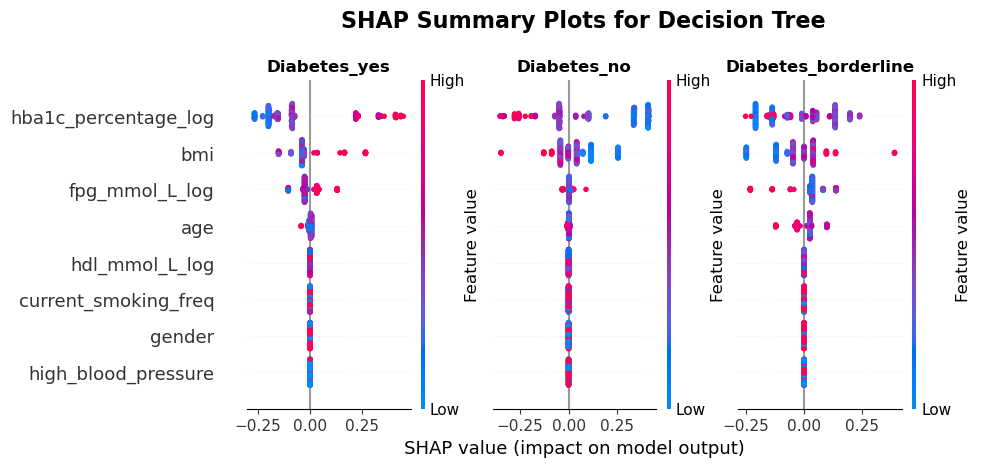

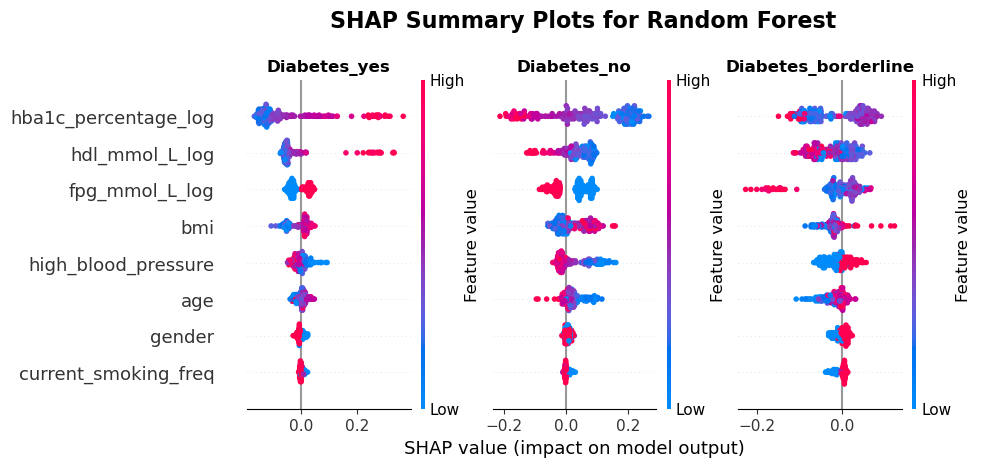

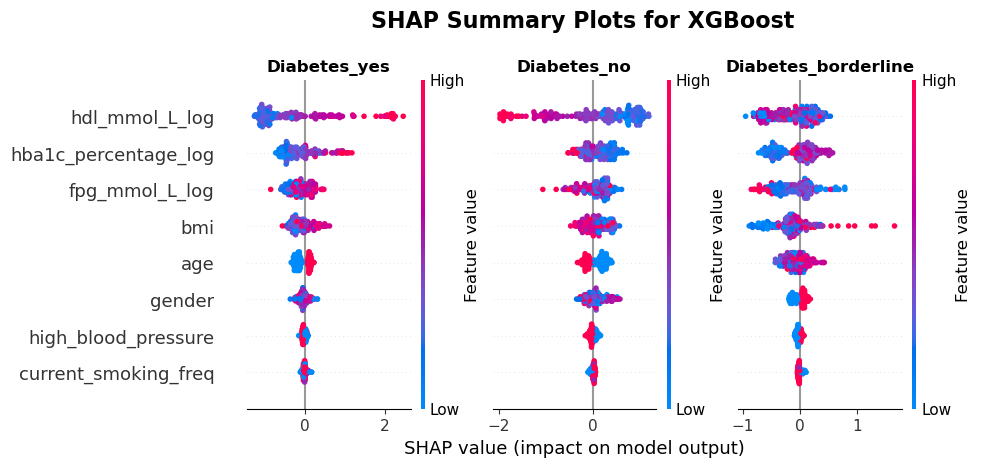

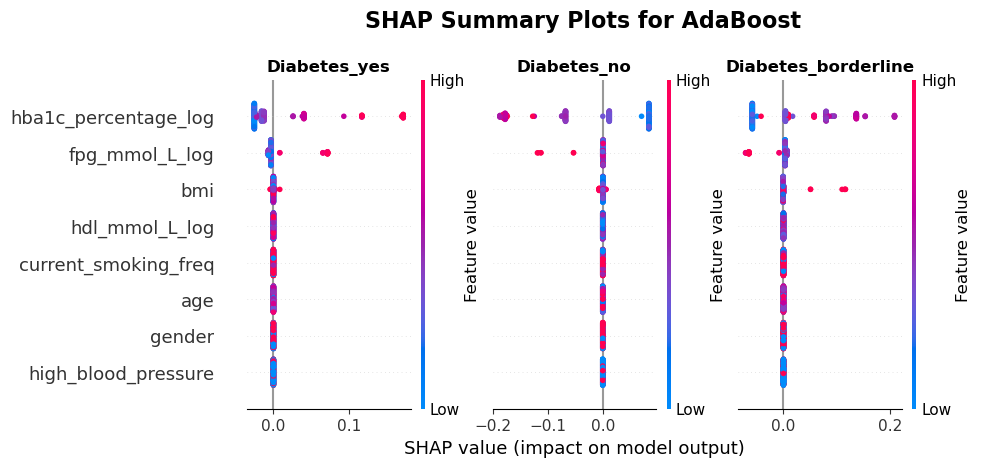

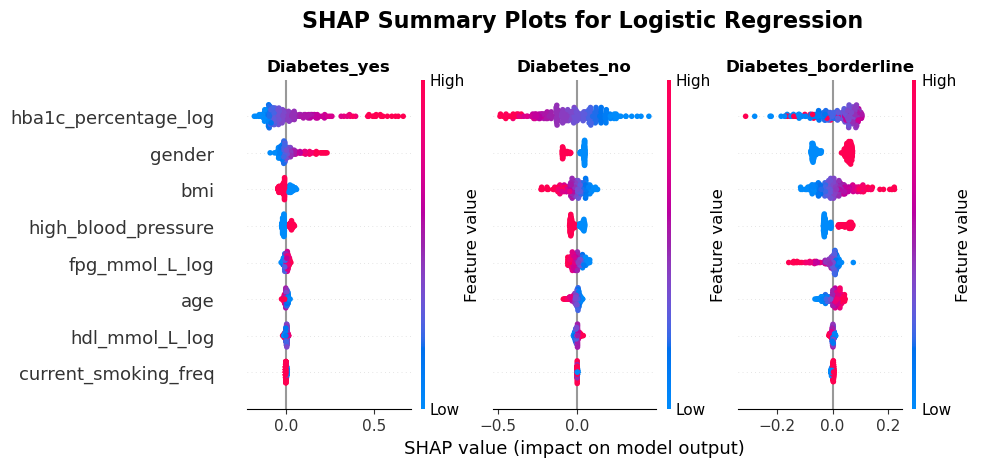

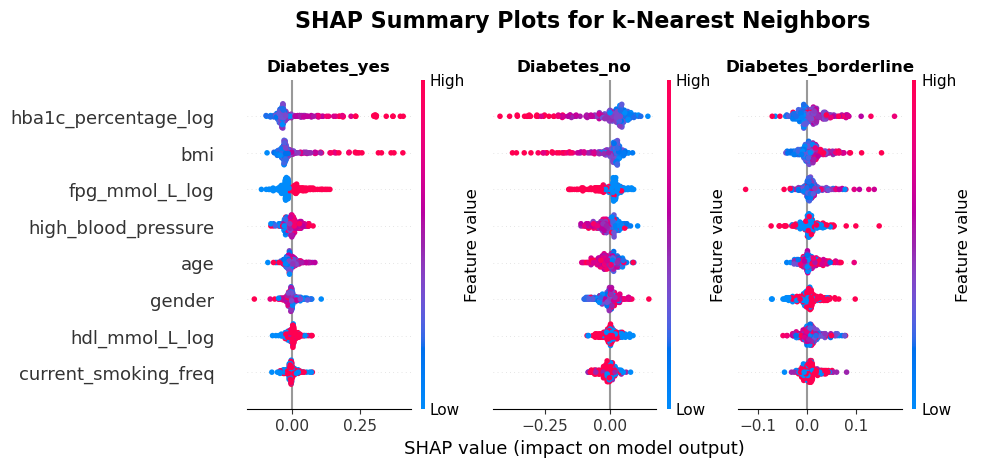

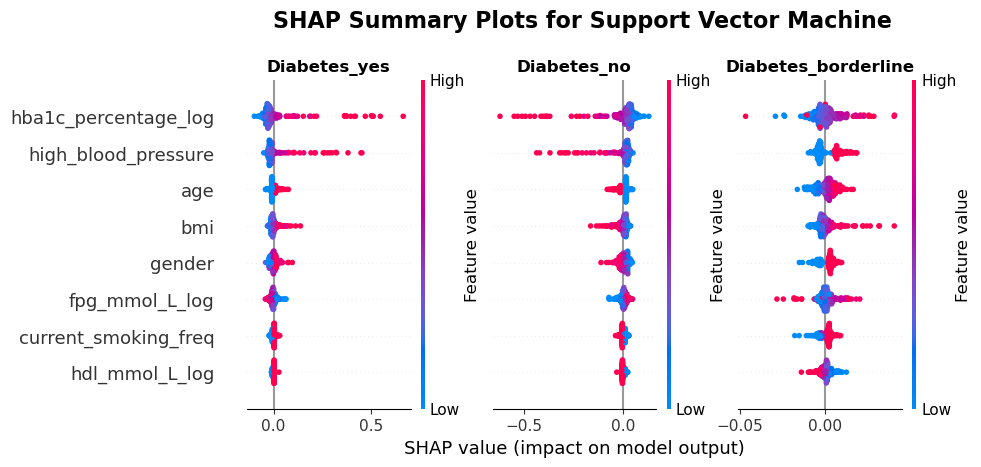

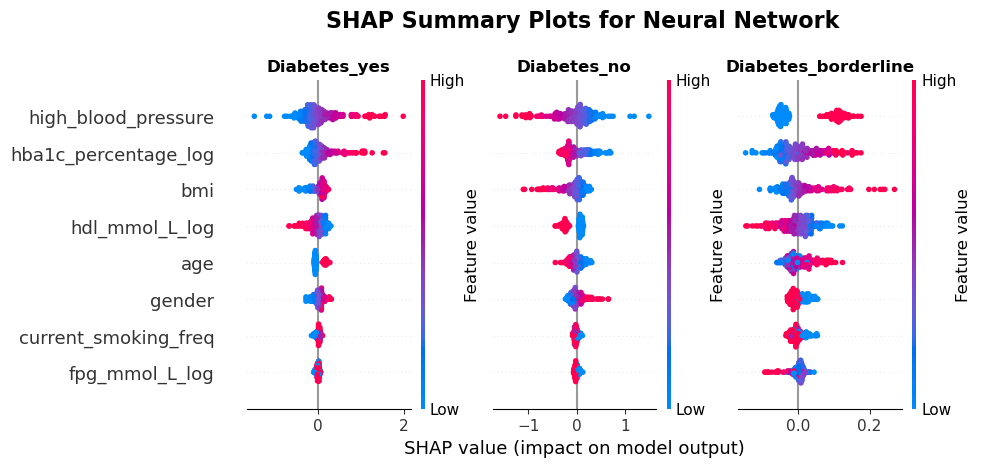

In [24]:
model_names = ["Decision Tree", "Random Forest", "XGBoost", "AdaBoost", "Logistic Regression", "k-Nearest Neighbors", "Support Vector Machine", "Neural Network"]
shap_values_list = [dt_shap_values, rf_shap_values, xgb_shap_values, adb_shap_values, lgr_shap_values, knn_shap_values, svc_shap_values, nn_shap_values]
class_names = ["Diabetes_yes", "Diabetes_no", "Diabetes_borderline"]

for model_idx, (shap_values, model_name) in enumerate(zip(shap_values_list, model_names)):
    fig, axes = plt.subplots(1, 3, figsize=(18,6), sharey=True)
    fig.suptitle(f"SHAP Summary Plots for {model_name}", fontweight="bold", y=1, fontsize=16)

    for class_idx in range(len(class_names)):
        ax = axes[class_idx]
        plt.sca(ax)
        
        X_data = X_test_scaled if model_name == "Neural Network" else X_test

        ax.set_title(f"{class_names[class_idx]}", fontweight="bold")
        shap.summary_plot(shap_values[:, :, class_idx], X_data, feature_names=feature_names, show=False)
        
        if class_idx != 1:
            ax.set_xlabel("")
            
    plt.tight_layout()
    plt.subplots_adjust(top=0.85, bottom=0.15, left=0.08, right=0.95, wspace=0.2)
    plt.show()